### Least square solving with u.n_s = v_s.n_s

In [11]:
import numpy as np
import scipy.optimize
import math
import matplotlib.pyplot as plt


def velocity_frame(pos, vel, size):
    frame = np.zeros(size * size * 2)
    for p in pos:
        frame[(p[0] * size + p[1]) * 2] = vel[0]
        frame[(p[0] * size + p[1]) * 2 + 1] = vel[1]

    return frame

def normals_frame(pos, normals, size):
    frame = np.zeros(size * size * 2)
    for p, n in zip(pos, normals):
        frame[(p[0] * size + p[1]) * 2] = n[0]
        frame[(p[0] * size + p[1]) * 2 + 1] = n[1]

    return frame

# Positions = np.array([])
Velocities = np.array([])
Normals = np.array([])
Times = np.array([])

BodyNormals = []
grid_res = 0
N_points = 0
skipped = 0

min_x = 20
max_x = 0
min_y = 20
max_y = 0

file = "accelerations_input_3"
print("Opening file:", file)
print("Reading...")
with open(file) as acc_file:
    N_boundary_cells = int(acc_file.readline())
    N_inner_cells = int(acc_file.readline())
    N_curves = int(acc_file.readline())
    grid_res = int(acc_file.readline())
    grid_res = 8
    print("curves:", N_curves)
    print("boundary cells:", N_boundary_cells)
    print("inner cells:", N_inner_cells)
    print("grid size: ", grid_res)

    # read normals
    for _ in range(N_boundary_cells):
        BodyNormals.append(list(map(float, acc_file.readline().split())))
    
    for _ in range(min(1, N_curves)):
        N_points = int(acc_file.readline())
        print("size of curve:", N_points)
        for i in range(N_points):
            boundary_pos = []
            inner_pos = []
            times = []

            # times.append(float(acc_file.readline()))  # should be added when a point is passed

            # read body pos
            for _ in range(N_boundary_cells):
                boundary_pos.append(list(map(int, acc_file.readline().split())))

                min_x = min(min_x, boundary_pos[-1][0])
                max_x = max(max_x, boundary_pos[-1][0])
                min_y = min(min_y, boundary_pos[-1][1])
                max_y = max(max_y, boundary_pos[-1][1])

            for _ in range(N_inner_cells):
                inner_pos.append(list(map(int, acc_file.readline().split())))
                if i == 0 or i == N_points - 1:
                    print(inner_pos[0])

            # read velocity (and acceleration that is not used)
            # pos = list(map(float, acc_file.readline().split()))
            vel = list(map(float, acc_file.readline().split()))
            acc = list(map(float, acc_file.readline().split()))

            if not math.isnan(vel[0]):
                # Positions += inner_pos
                Velocities = np.concatenate((Velocities, velocity_frame(boundary_pos + inner_pos, vel, grid_res)))
                Normals = np.concatenate((Normals, normals_frame(boundary_pos, BodyNormals, grid_res)))
                # Times = np.concatenate((Times, np.array(times)))
            else:
                skipped += 1


N_points -= skipped
print("Points skipped:", skipped)

print('Finished reading the file, total:')
print('Velocities shape:', Velocities.shape)
print('Normals shape:', Normals.shape)

# Times.reshape((N_curves, N_points))

print(min_x, min_y, max_x, max_y)

Opening file: accelerations_input_3
Reading...
curves: 2
boundary cells: 8
inner cells: 1
grid size:  8
size of curve: 70
[2, 4]
[6, 4]
Points skipped: 1
Finished reading the file, total:
Velocities shape: (8832,)
Normals shape: (8832,)
1 1 7 7


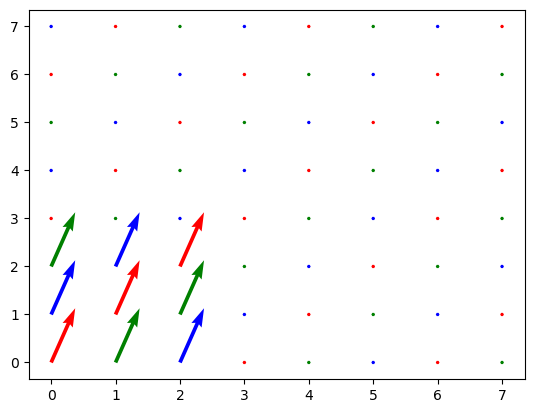

/usr/lib/python3/dist-packages/scipy/optimize/_constraints.py:386: OptimizeWarning: At least one constraint is unbounded above and below. Such constraints are ignored.
  warn("At least one constraint is unbounded above and below. Such "


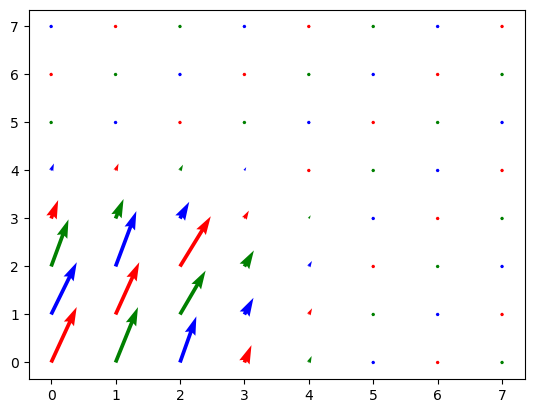

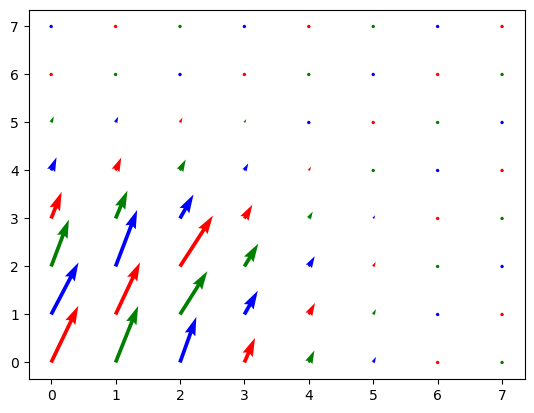

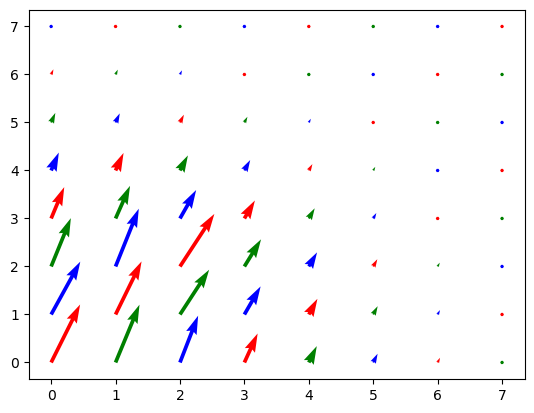

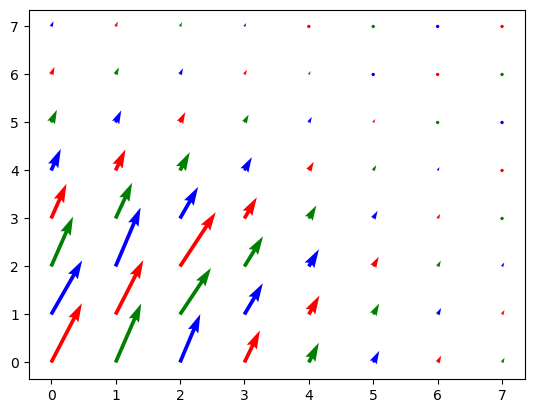

In [3]:
### for the frames of one curve

V = Velocities.copy()
N = Normals.copy()

n_frames = N_points
width = grid_res
height = grid_res
cells = width * height

Uinit = np.zeros(n_frames * width * height * 2)
U = np.zeros(n_frames * width * height * 2)

X = np.zeros(width * height)
Y = np.zeros(width * height)
for i in range(height):
    for j in range(width):
        X[i * width + j] = i
        Y[i * width + j] = j
P = np.array([X, Y])

for frame in range(5):
# for frame in range(n_frames):
    # Get data corresponding to the considered frame
    UinitFrame = Uinit[frame * cells * 2: (frame+1) * cells * 2]
    NFrame = N[frame * cells * 2: (frame+1) * cells * 2]
    VFrame = V[frame * cells * 2: (frame+1) * cells * 2]

    assert len(NFrame) == cells * 2

    # Set the constraint equality
    A = np.zeros([cells, cells * 2])
    B = np.zeros([cells])
    for cell in range(cells):
        A[cell, cell * 2: (cell+1) * 2] = NFrame[cell * 2: (cell+1) * 2]
        B[cell] = np.dot(VFrame[cell * 2: (cell+1) * 2],
                         NFrame[cell * 2: (cell+1) * 2])
    Binf = np.copy(B)
    Bsup = np.copy(B)
    for cell in range(cells):
        if B[cell] == 0:
            Binf[cell] = -np.inf
            Bsup[cell] = np.inf
            A[cell] = np.ones(cells * 2)

    # cons = ({'type': 'eq', 'fun': lambda x:  A @ x - B})
    cons = scipy.optimize.LinearConstraint(A, Binf, Bsup)
    # cons = scipy.optimize.LinearConstraint(A, lb=B, ub=B, keep_feasible=False)

    # Solve
    if frame == 0:
        UFrame = VFrame
    else:
        def f(x):
            timeGradient = x-U[(frame-1) * cells * 2: frame * cells * 2]
            firstSpaceDimGradient = x[: (cells-width) * 2] - x[width * 2:]
            xWithoutFirstCol = np.array([x[i] for i in range(cells * 2) if i % (width * 2) != 0 and i % (width * 2) != 1])
            xWithoutLastCol = np.array([x[i] for i in range(cells * 2) if i % (width * 2) != (width * 2 - 2) and i % (width * 2) != (width * 2 - 1)])
            secondSpaceDimGradient = xWithoutLastCol - xWithoutFirstCol
            # spaceGradient = firstSpaceDimGradient + secondSpaceDimGradient
            return np.sum(firstSpaceDimGradient**2) + np.sum(secondSpaceDimGradient**2) + np.sum(timeGradient**2)
        resFrame = scipy.optimize.minimize(f, UinitFrame, constraints=cons)
        UFrame = resFrame.x

    # Display N, V and U
    # plt.quiver(*P, np.array([NFrame[i] for i in range(0, 2*cells, 2)]),
    #            np.array([NFrame[i] for i in range(1, 2*cells, 2)]), color=['r', 'b', 'g'], scale=21)
    # plt.show()

    # plt.quiver(*P, np.array([VFrame[i] for i in range(0, 2*cells, 2)]),
    #            np.array([VFrame[i] for i in range(1, 2*cells, 2)]), color=['r', 'b', 'g'], scale=21)
    # plt.show()

    plt.quiver(*P, np.array([UFrame[i] for i in range(0, 2 * cells, 2)]),
               np.array([UFrame[i] for i in range(1, 2*cells, 2)]), color=['r', 'b', 'g'], scale=0.15)
    # plt.savefig('example_initial/frame_' + str(frame) + '.png')
    plt.show()

    U[(2*cells)*frame:(2*cells)*(frame+1)] = UFrame

### Fluid simulation

In [4]:
#renew U_sf

U_sf = UFrame.copy()
U_sf = U_sf.reshape((height, width, 2))
U_ref = U_sf.copy()

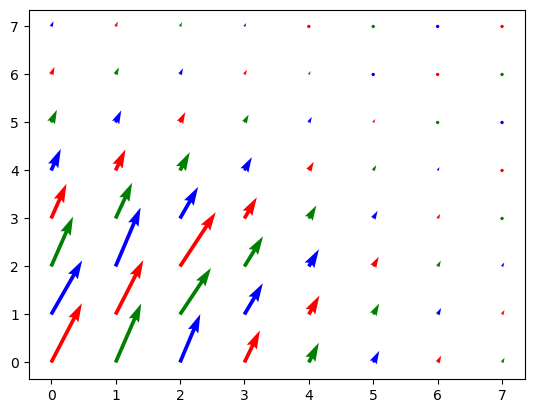

In [5]:
# show current U_sf

plt.quiver(*P, np.array(U_sf[:, :, 0]), np.array(U_sf[:, :, 1]), color=['r', 'b', 'g'], scale=0.15)
plt.show()

In [8]:
# get and diffuse

def get(U, x, y):
    if x < 0:
        return get(U, 0, y)
    if x >= height:
        return get(U, height - 1, y)
    if y < 0:
        return get(U, x, 0)
    if y >= width:
        return get(U, x, width - 1)
    return U[int(x), int(y)]


def diffuse(U):
    mu = 0.2
    dt = 0.2
    a = mu * dt
    b = 1. / (1. + 4 * a)
    new_U = U.copy()

    for i in range(20):
        for x in range(height):
            for y in range (width):
                new_U[x, y] = b * (get(U, x, y) + a * (get(new_U, x - 1, y) + get(new_U, x + 1, y) + get(new_U, x, y - 1) + get(new_U, x, y + 1)))
    set_boundaries(new_U)
    
    return new_U

[6.91966212e-07 1.55882498e-06] [0. 0.]


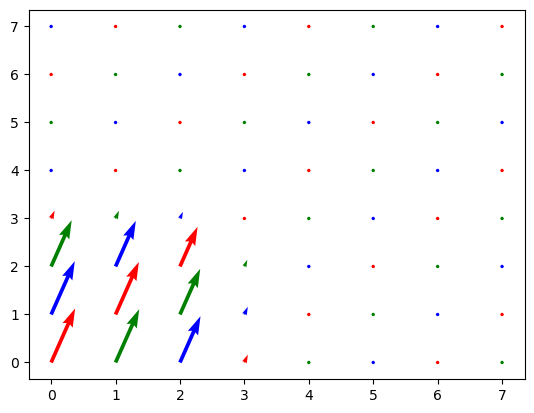

In [143]:
# apply diffuse

for i in range(1):
    U_sf = diffuse(U_sf)
    print(U_sf[1, 6], U_ref[1, 6])
    if i % 40 == 0:
        plt.quiver(*P, np.array(U_sf[:, :, 0]), np.array(U_sf[:, :, 1]), color=['r', 'b', 'g'], scale=0.15)
        # plt.savefig('diffuse/frame_' + str(i) + '.png')
        plt.show()

In [6]:
# interpolation and advect

from math import floor

def interpolation(U, x, y):
    x0 = floor(x)
    y0 = floor(y)

    if x0 == x and y0 == y:
        return get(U, x, y)

    x1 = x0 + 1
    y1 = y0 + 1

    dx = x - x0
    dy = y - y0

    ans = (1 - dx) * (1 - dy) * get(U, x0, y0)
    ans += (1 - dx) * dy * get(U, x0, y1)
    ans += dx * (1 - dy) * get(U, x1, y0)
    ans += dx * dy * get(U, x1, y1)

    # print(x, y, U[x0, y0], ans)

    return ans


def advect(U):
    dt = 10
    new_U = U.copy()

    for x in range(1, height - 1):
        for y in range (1, width - 1):
            # v = 0.25 * (interpolation(U, x + 0.5, y + 0.5) + interpolation(U, x + 0.5, y - 0.5) + interpolation(U, x - 0.5, y + 0.5) + interpolation(U, x - 0.5, y - 0.5))
            v = U[x, y]
            new_U[x, y] = interpolation(U, x - dt * v[0], y - dt * v[1])
            
    return new_U

[0.00035997 0.00081092] [0.00037032 0.00083425] 2.996400311036583 2.991890810576918


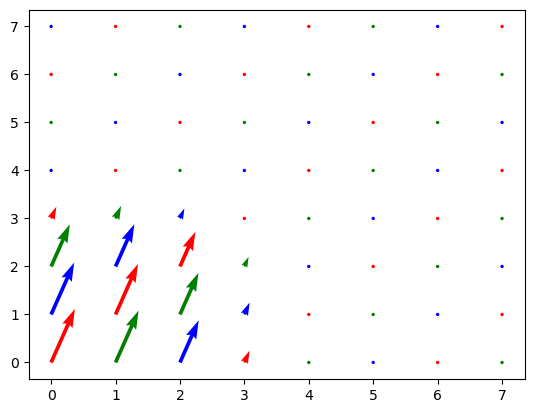

[0.00037032 0.00083425] [0.00038161 0.00085968] 2.9962967605261093 2.991657537448928


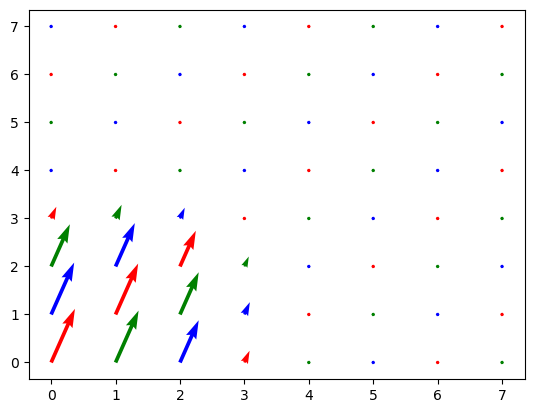

[0.00038161 0.00085968] [0.00039396 0.0008875 ] 2.9961838539116123 2.991403187383303


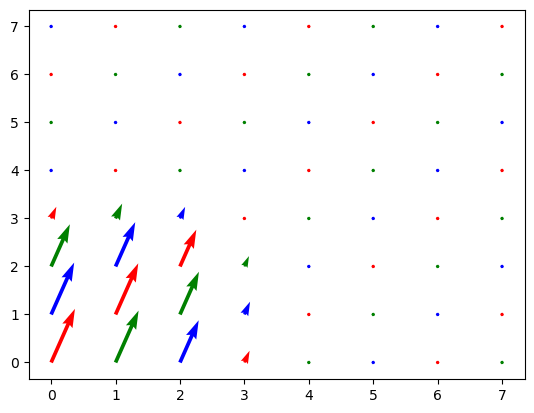

[0.00039396 0.0008875 ] [0.0004075 0.000918 ] 2.9960603806329256 2.9911250332939536


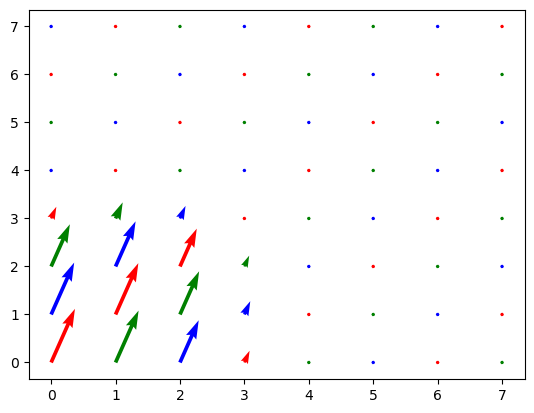

[0.0004075 0.000918 ] [0.0004224  0.00095155] 2.995924963356175 2.990819972395779


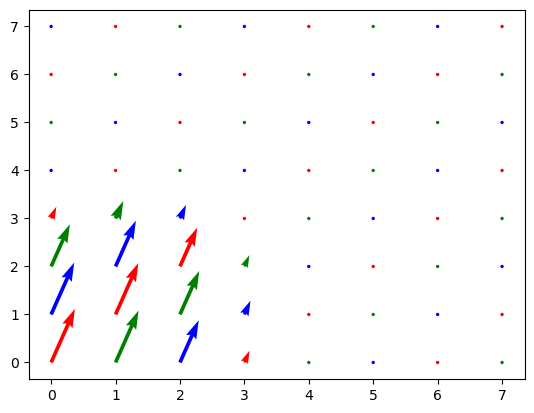

[0.0004224  0.00095155] [0.00043882 0.00098854] 2.995776040755852 2.990484487417029


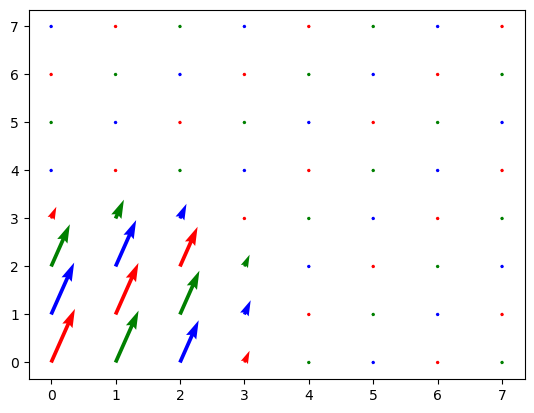

[0.00043882 0.00098854] [0.00045696 0.00102941] 2.9956118499970024 2.990114607136104


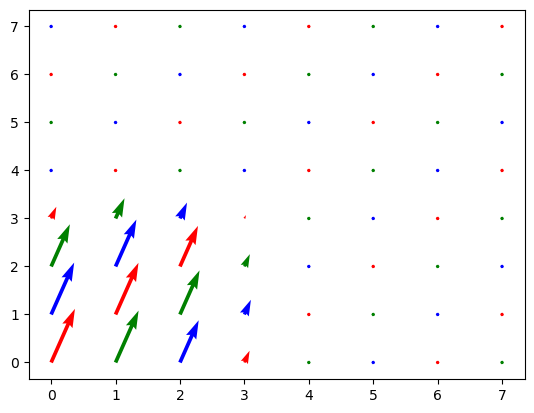

[0.00045696 0.00102941] [0.00047705 0.00107467] 2.9954304095012523 2.9897058675577664


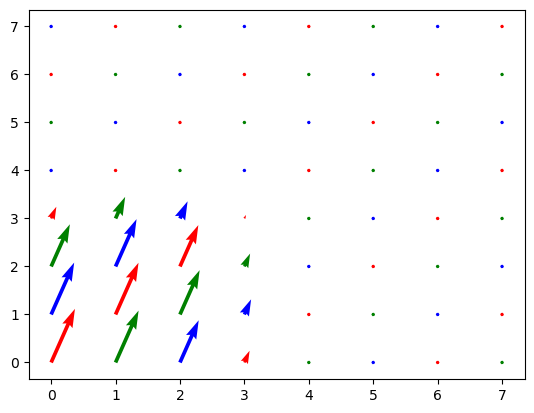

[0.00047705 0.00107467] [0.00049933 0.00112487] 2.9952295028097082 2.9892532755603316


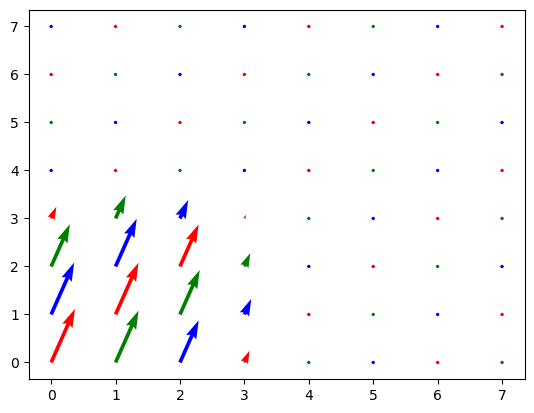

[0.00049933 0.00112487] [0.00052408 0.00118063] 2.9950066646158127 2.9887512774312266


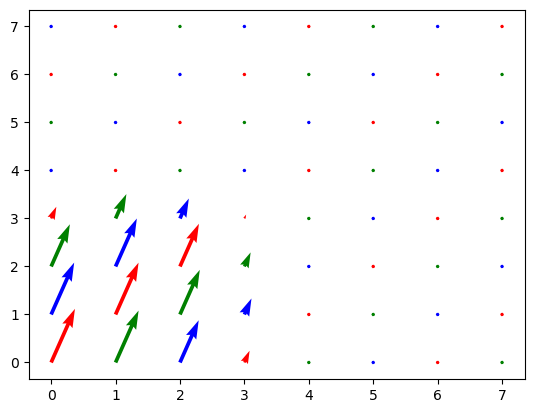

In [175]:
# apply advect

for i in range(10):
    U_sf = advect(U_sf)
    plt.quiver(*P, np.array(U_sf[:, :, 0]), np.array(U_sf[:, :, 1]), color=['r', 'b', 'g'], scale=0.15)
    # plt.savefig('advect/frame_' + str(i) + '.png')
    plt.show()

In [7]:
# divergence free

def set_boundaries(grid):
    for x in range(1, height - 1):
        grid[x, 0] = grid[x, 1]
        grid[x, width - 1] = grid[x, width - 2]

    for y in range(1, width):
        grid[0, y] = grid[1, y]
        grid[height - 1, y] = grid[height - 2, y]

    grid[0, 0] = (grid[1, 0] + grid[0, 1]) / 2.
    grid[height - 1, 0] = (grid[height - 2, 0] + grid[height - 1, 1]) / 2.
    grid[0, width - 1] = (grid[1, width - 1] + grid[0, width - 2]) / 2.
    grid[height - 1, width - 1] = (grid[height - 2, width - 1] + grid[height - 1, width - 2]) / 2.

def set_boundaries_reflective(grid):
    set_boundaries(grid)
    for x in range(1, height - 1):
        grid[x, 0][1] *= -1.
        grid[x, width - 1][1] *= -1.

    for y in range(1, width - 1):
        grid[0, y][0] *= -1.
        grid[height - 1, y][0] *= -1.


def divergence_free(U):
    new_U = U.copy()
    divergence = np.zeros((height, width))
    gradient_field = np.zeros((height, width))

    for x in range(1, height - 1):
        for y in range (1, width - 1):
            divergence[x, y] = (get(U, x + 1, y)[0] - get(U, x - 1, y)[0] + get(U, x, y + 1)[1] - get(U, x, y - 1)[1]) / 2
    set_boundaries(divergence)

    for _ in range(15):
        for x in range(1, height - 1):
            for y in range (1, width - 1):
                gradient_field[x, y] = (gradient_field[x - 1, y] + gradient_field[x + 1, y] + gradient_field[x, y - 1] + gradient_field[x, y + 1] - divergence[x, y]) / 4.
    set_boundaries(gradient_field)

    for x in range(1, height - 1):
        for y in range (1, width - 1):
            nabla_q = np.array([(gradient_field[x + 1, y] - gradient_field[x - 1, y]) / 2, (gradient_field[x, y + 1] - gradient_field[x, y - 1]) / 2])
            new_U[x, y] = get(U, x, y) - nabla_q
    set_boundaries(new_U)

    return new_U


[0.00437672 0.00651596] [0.00444485 0.00666897] 2.9562328325052634 2.934840422414515


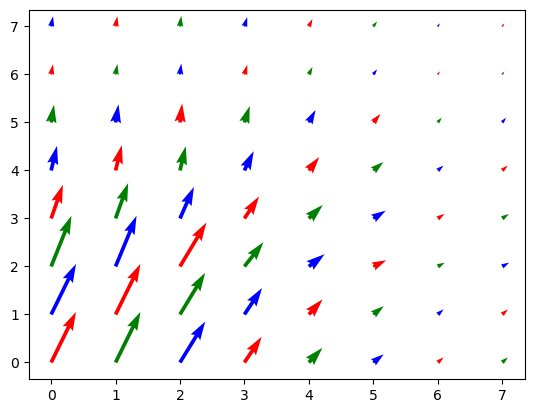

[0.00493894 0.00688258] [0.00496263 0.00700679] 2.9506105558466995 2.9311741976258325


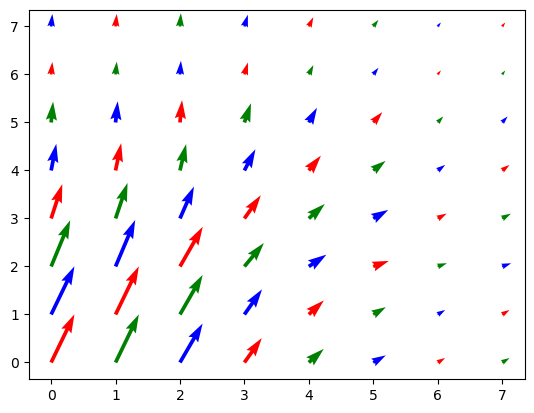

[0.00527959 0.00714272] [0.00528342 0.00726017] 2.9472040649746543 2.9285728435789586


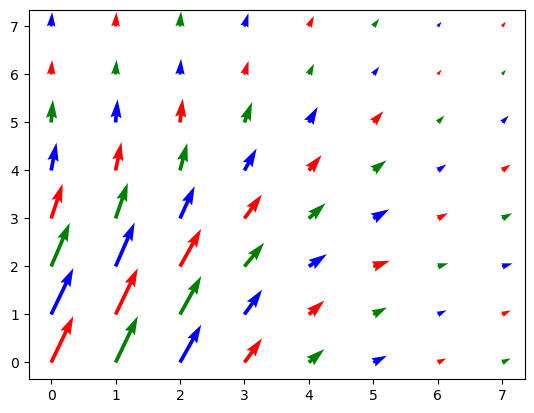

[0.00548073 0.00732304] [0.00547544 0.00743972] 2.945192743765579 2.9267695624401573


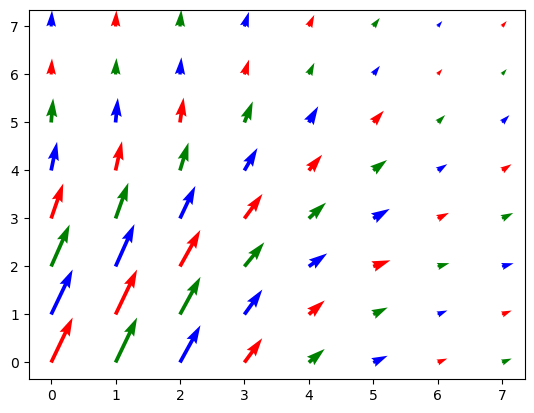

[0.00560182 0.00745654] [0.00559215 0.00757357] 2.943981756860367 2.9254346242410874


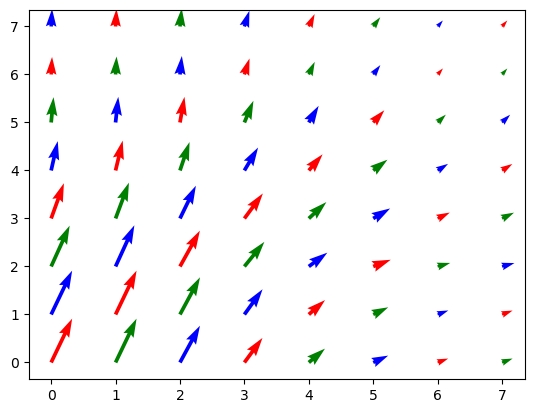

In [9]:
for i in range(5):
    U_sf = diffuse(U_sf)
    U_sf = divergence_free(U_sf)
    U_sf = advect(U_sf)
    plt.quiver(*P, np.array(U_sf[:, :, 0]), np.array(U_sf[:, :, 1]), color=['r', 'b', 'g'], scale=0.15)
    # plt.savefig('advect/frame_' + str(i) + '.png')
    plt.show()

### Combine the optimization and simulation

In [ ]:
### for the frames of one curve now together with stable fluids

V = Velocities.copy()
N = Normals.copy()

Uinit = np.zeros(n_frames * width * height * 2)
U = np.zeros(n_frames * width * height * 2)

X = np.zeros(width * height)
Y = np.zeros(width * height)
for i in range(height):
    for j in range(width):
        X[i * width + j] = i
        Y[i * width + j] = j
P = np.array([X, Y])

for frame in range(n_frames):
    # Get data corresponding to the considered frame
    UinitFrame = Uinit[frame * cells * 2: (frame+1) * cells * 2]
    NFrame = N[frame * cells * 2: (frame+1) * cells * 2]
    VFrame = V[frame * cells * 2: (frame+1) * cells * 2]

    assert len(NFrame) == cells * 2

    # Set the constraint equality
    A = np.zeros([cells, cells * 2])
    B = np.zeros([cells])
    for cell in range(cells):
        A[cell, cell * 2: (cell+1) * 2] = NFrame[cell * 2: (cell+1) * 2]
        B[cell] = np.dot(VFrame[cell * 2: (cell+1) * 2],
                        NFrame[cell * 2: (cell+1) * 2])
    Binf = np.copy(B)
    Bsup = np.copy(B)
    for cell in range(cells):
        if B[cell] == 0:
            Binf[cell] = -np.inf
            Bsup[cell] = np.inf
            A[cell] = np.ones(cells * 2)

    cons = scipy.optimize.LinearConstraint(A, Binf, Bsup)

    # Solve
    if frame == 0:
        UFrame = VFrame
    else:
        def f(x):
            timeGradient = x-U[(frame-1) * cells * 2: frame * cells * 2]
            firstSpaceDimGradient = x[: (cells-width) * 2] - x[width * 2:]
            xWithoutFirstCol = np.array([x[i] for i in range(cells * 2) if i % (width * 2) != 0 and i % (width * 2) != 1])
            xWithoutLastCol = np.array([x[i] for i in range(cells * 2) if i % (width * 2) != (width * 2 - 2) and i % (width * 2) != (width * 2 - 1)])
            secondSpaceDimGradient = xWithoutLastCol - xWithoutFirstCol
            return np.sum(firstSpaceDimGradient**2) + np.sum(secondSpaceDimGradient**2) + np.sum(timeGradient**2)
        resFrame = scipy.optimize.minimize(f, UinitFrame, constraints=cons)
        UFrame = resFrame.x

    plt.quiver(*P, np.array([UFrame[i] for i in range(0, 2 * cells, 2)]),
            np.array([UFrame[i] for i in range(1, 2*cells, 2)]), color=['r', 'b', 'g'], scale=0.15)
    # plt.savefig('example_raw/frame_' + str(frame) + '.png')
    plt.show()

    for _ in range(3):
        UFrame = UFrame.reshape((height, width, 2))
        UFrame = diffuse(UFrame)
        UFrame = divergence_free(UFrame)
        UFrame = advect(UFrame)
        UFrame = UFrame.reshape(height * width * 2)


    U[(2*cells)*frame:(2*cells)*(frame+1)] = UFrame


    plt.quiver(*P, np.array([UFrame[i] for i in range(0, 2 * cells, 2)]),
            np.array([UFrame[i] for i in range(1, 2*cells, 2)]), color=['r', 'b', 'g'], scale=0.15)
    plt.savefig('example_ini_div_free_2/frame_' + str(frame) + '.png')
    plt.show()

### Let's put the object to the flow we built

0 [1. 1.] [0.00678408 0.01528281]


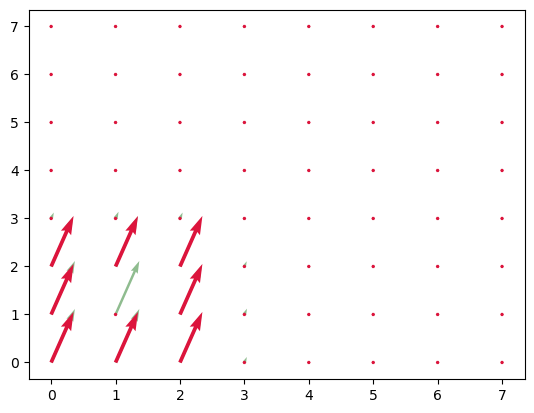

1 [1.02713631 1.06113125] [0.00685109 0.01433158]


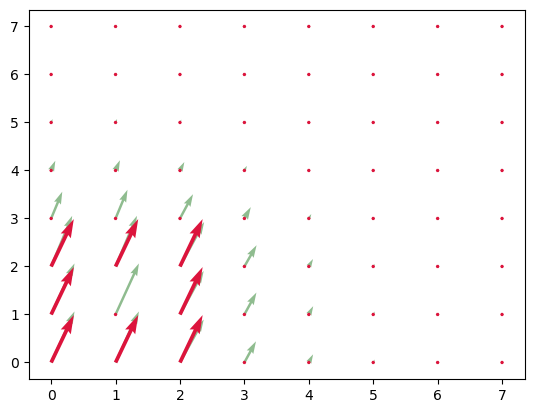

2 [1.05454067 1.11845756] [0.00732141 0.01462753]


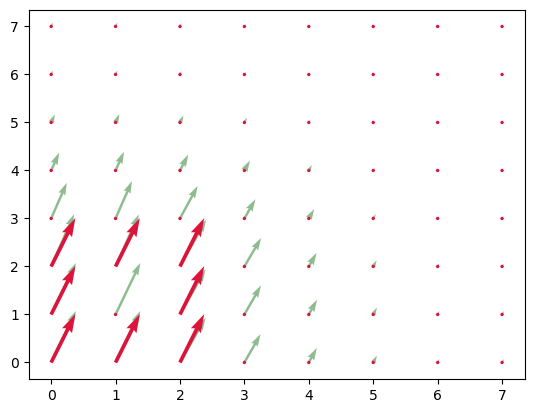

3 [1.08382629 1.17696766] [0.007854   0.01511365]


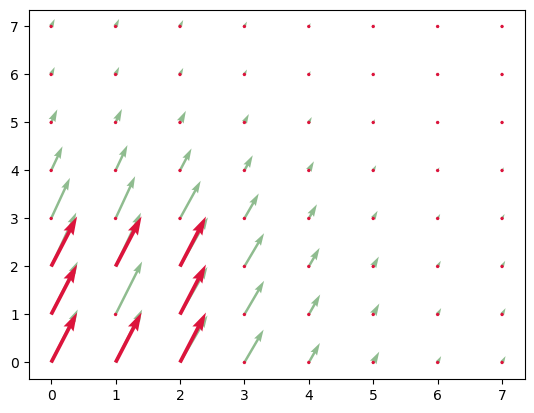

4 [1.11524228 1.23742228] [0.00839936 0.01560278]


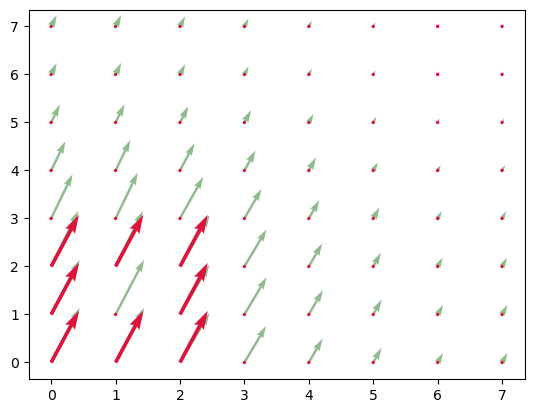

5 [1.14883973 1.2998334 ] [0.00933818 0.01633197]


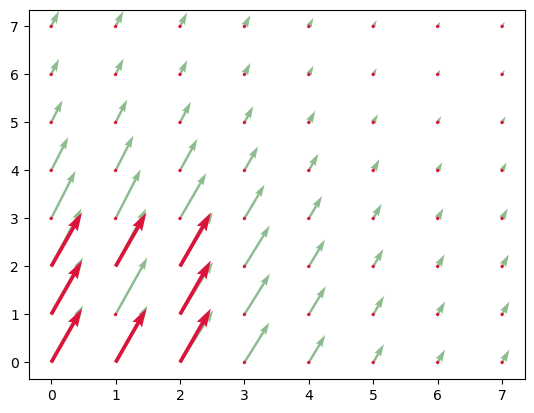

6 [1.18619245 1.3651613 ] [0.01030533 0.01695784]


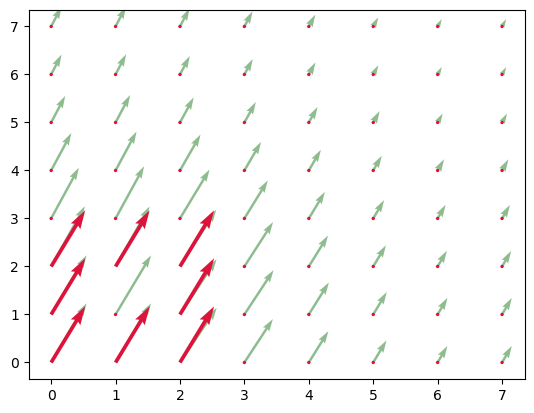

7 [1.22741377 1.43299268] [0.01280169 0.01836666]


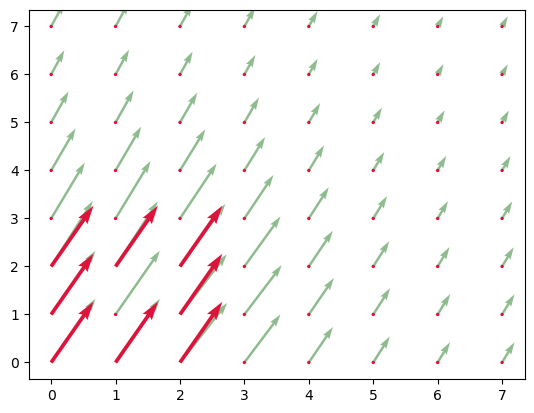

8 [1.27862051 1.50645932] [0.0140174  0.01955236]


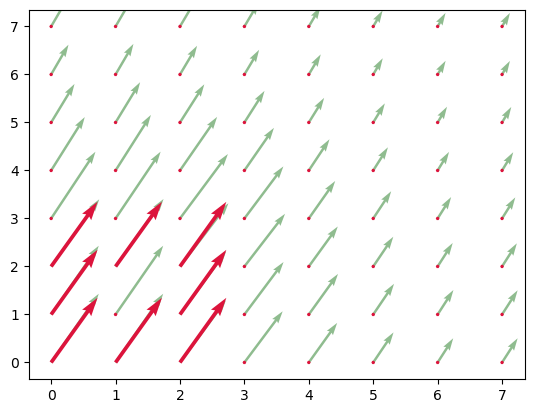

9 [1.3346901  1.58466874] [0.01641876 0.02052196]


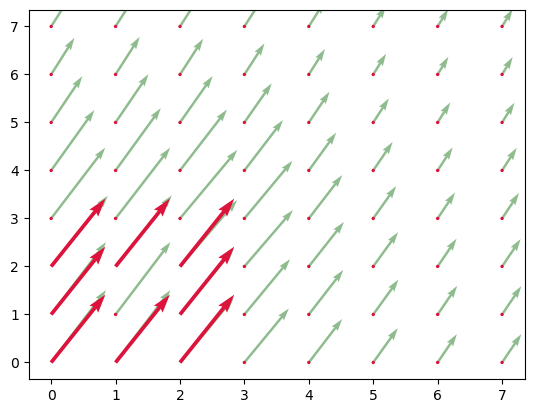

10 [1.40036514 1.66675657] [0.02017227 0.02193614]


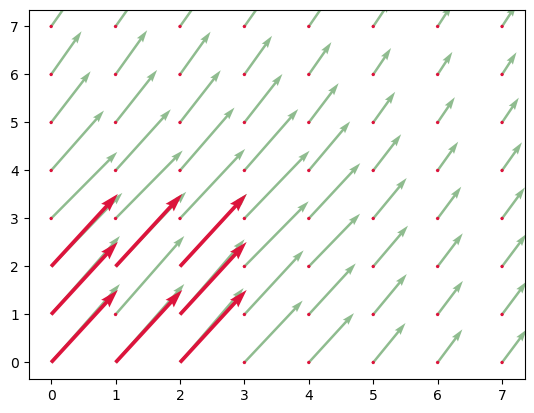

11 [1.48105421 1.75450113] [0.02219462 0.02205846]


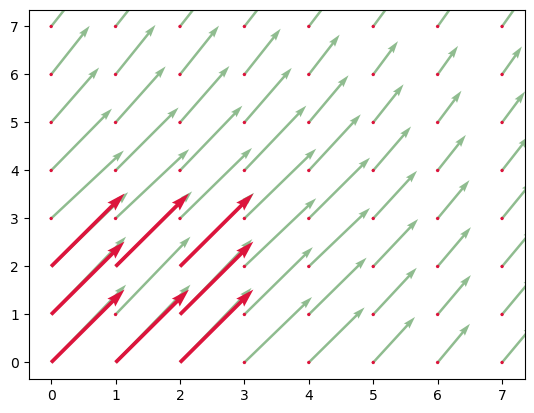

12 [1.56983269 1.84273495] [0.02362707 0.02165377]


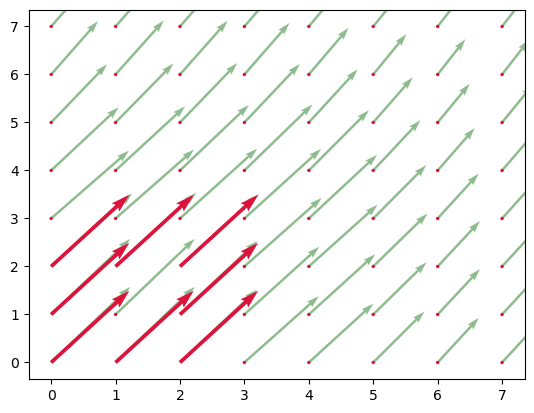

13 [1.66434097 1.92935003] [0.0248611  0.02112144]


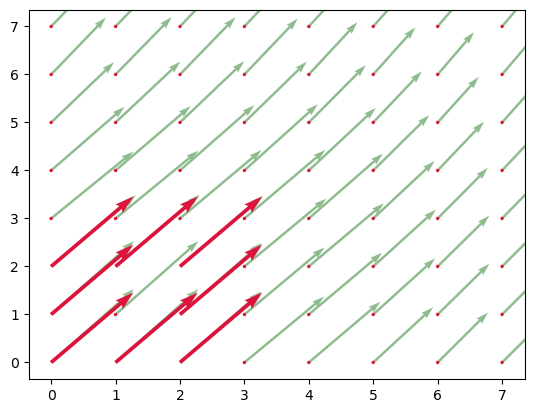

14 [1.76378537 2.0138358 ] [0.02595594 0.02022507]


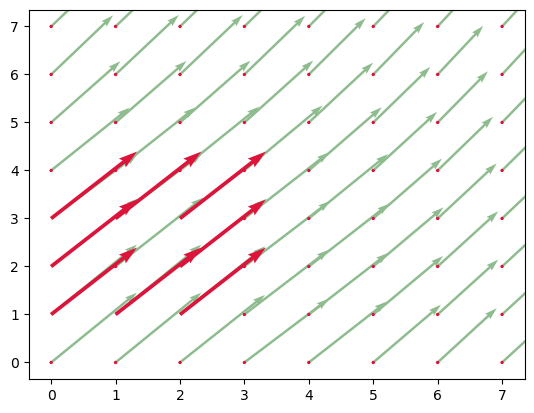

15 [1.86760911 2.09473607] [0.02679241 0.01916852]


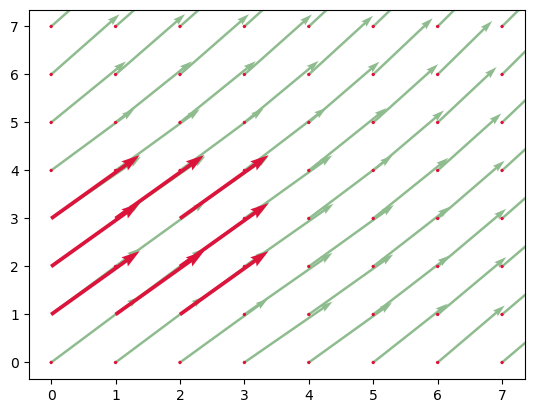

16 [1.97477875 2.17141015] [0.0274484  0.01839042]


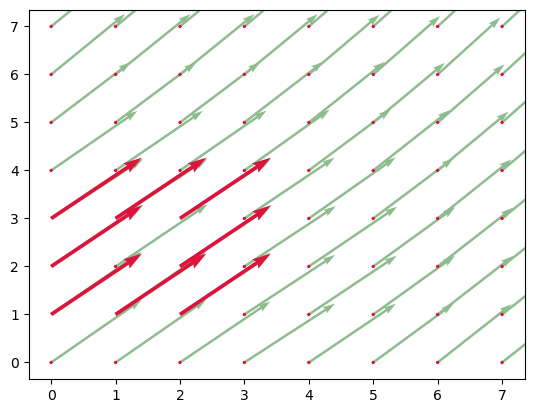

17 [2.08457234 2.24497182] [0.02803103 0.01735975]


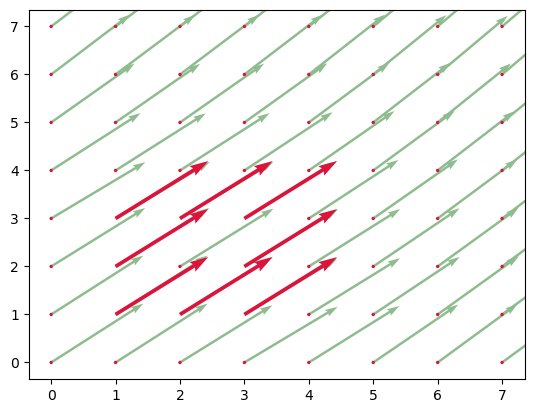

18 [2.19669647 2.31441083] [0.02817324 0.0161131 ]


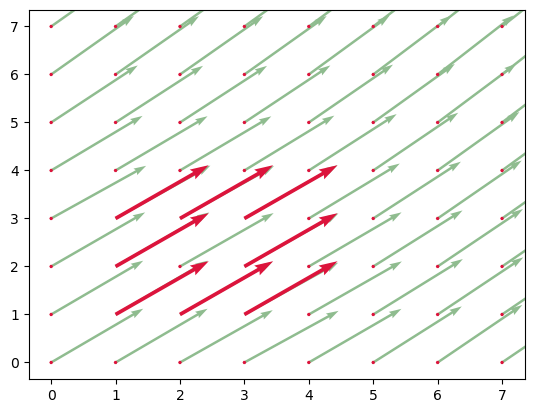

19 [2.30938942 2.37886324] [0.02822579 0.01501003]


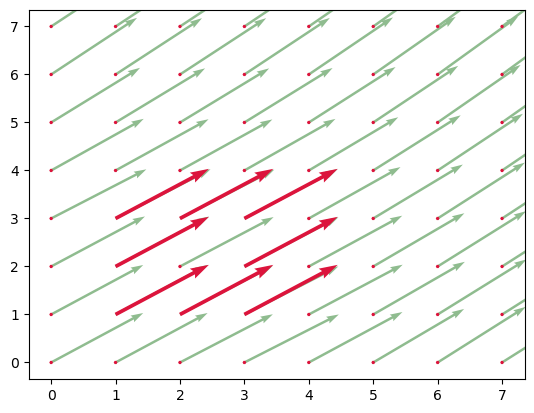

20 [2.42229257 2.43890337] [0.02796165 0.01356305]


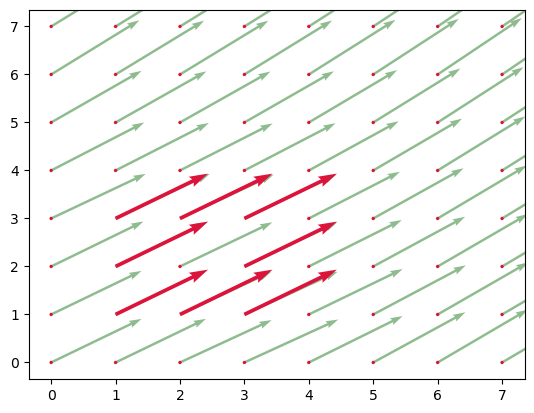

21 [2.53413919 2.49315559] [0.02745741 0.01238841]


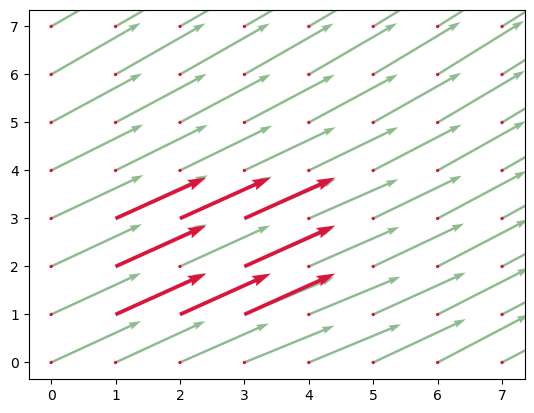

22 [2.64396881 2.54270924] [0.0269461  0.01136967]


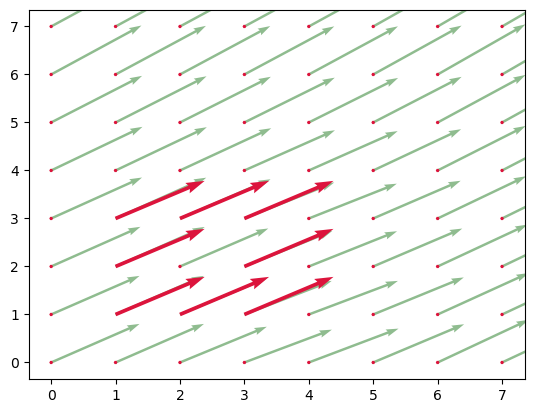

23 [2.75175319 2.58818792] [0.02652151 0.01042019]


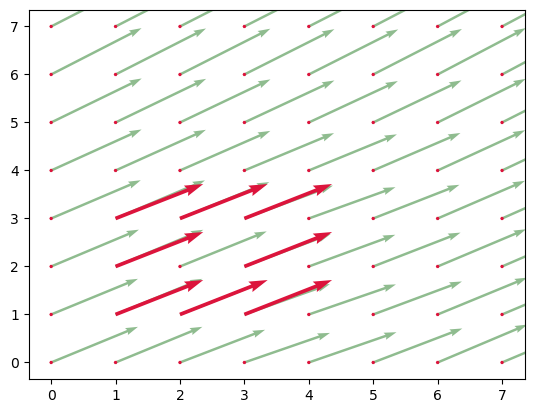

24 [2.85783924 2.62986867] [0.02609703 0.00945154]


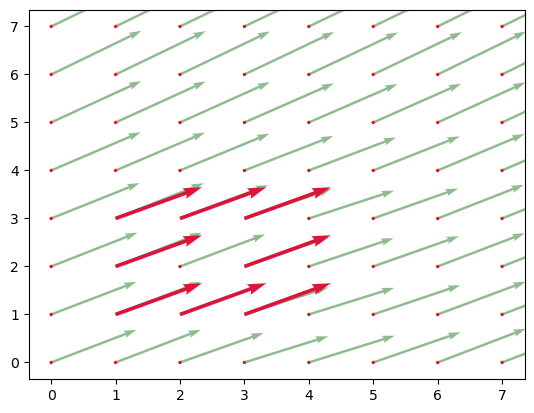

25 [2.96222737 2.66767484] [0.02564744 0.0082795 ]


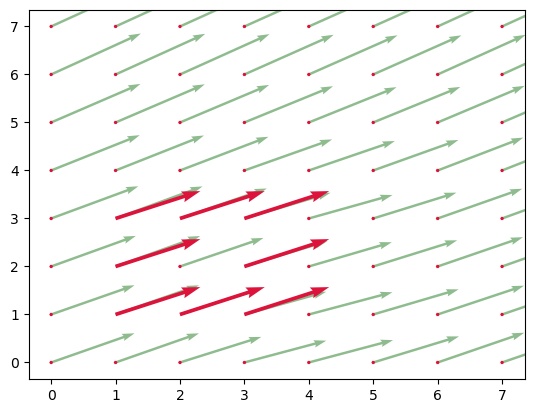

26 [3.06481715 2.70079285] [0.02513837 0.00701648]


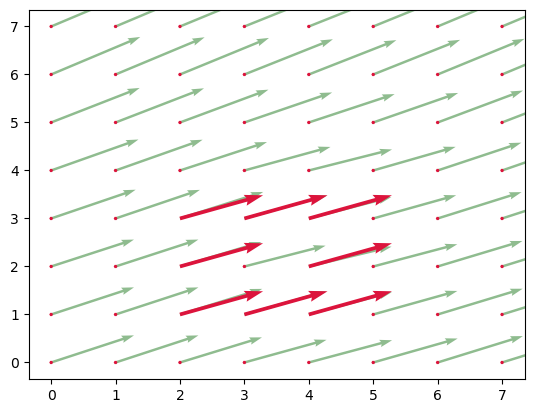

27 [3.16537063 2.72885877] [0.02498116 0.00613938]


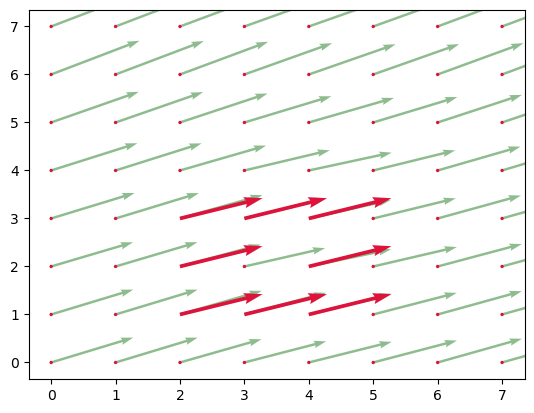

28 [3.26529527 2.75341629] [0.0249156  0.00549226]


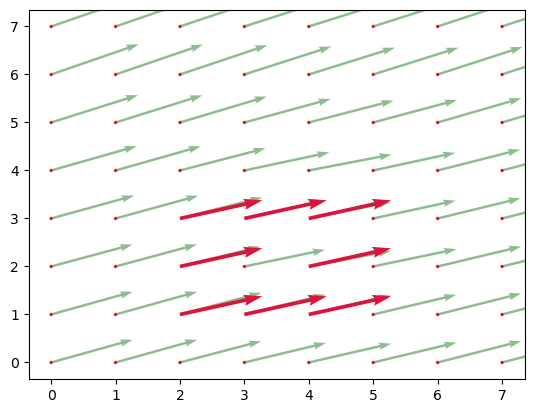

29 [3.36495767 2.77538534] [0.02499117 0.00476339]


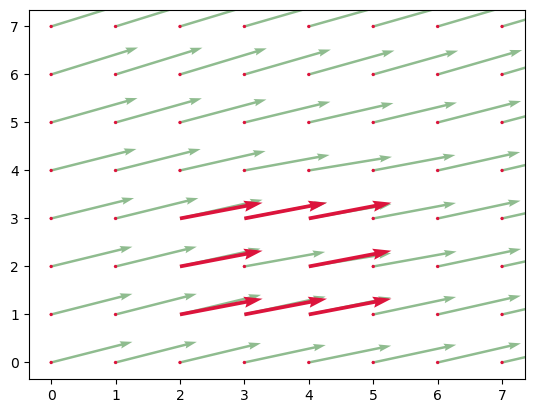

30 [3.46492236 2.79443889] [0.0251844  0.00408385]


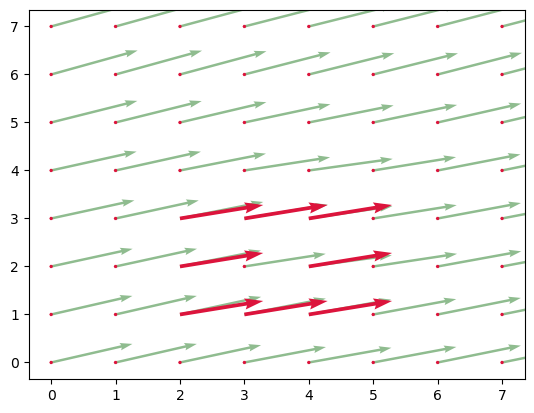

31 [3.56565996 2.81077429] [0.02560082 0.00337081]


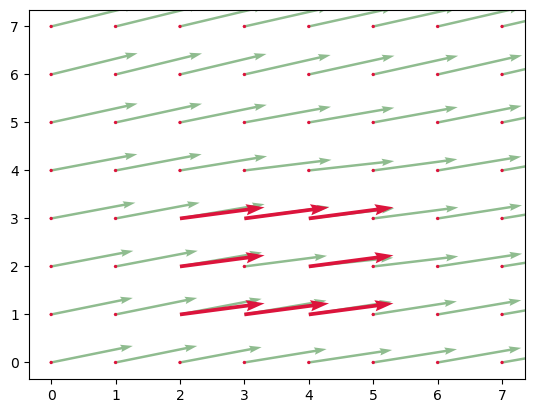

32 [3.66806323 2.82425754] [0.02603042 0.00285088]


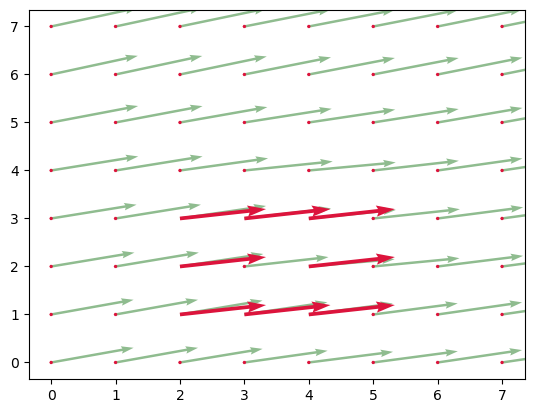

33 [3.7721849  2.83566108] [0.02650761 0.00271295]


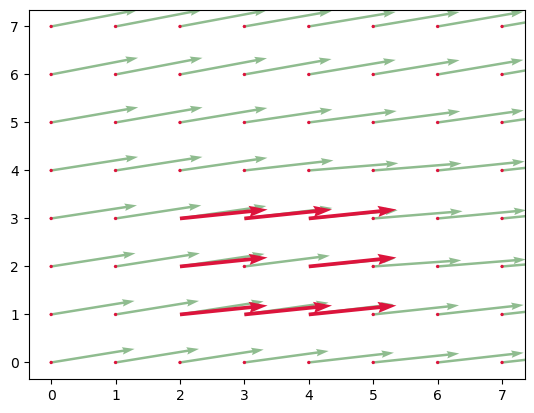

34 [3.87821535 2.84651287] [0.0267995  0.00260824]


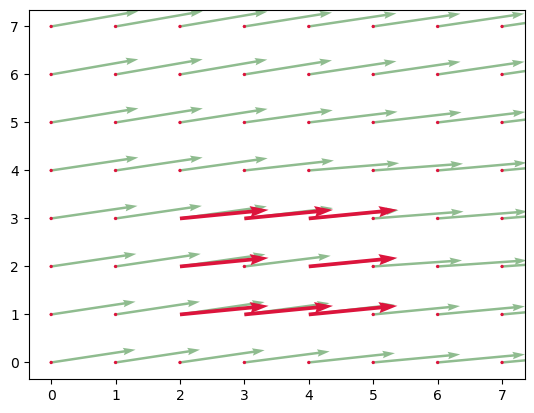

35 [3.98541336 2.85694584] [0.02695013 0.00269701]


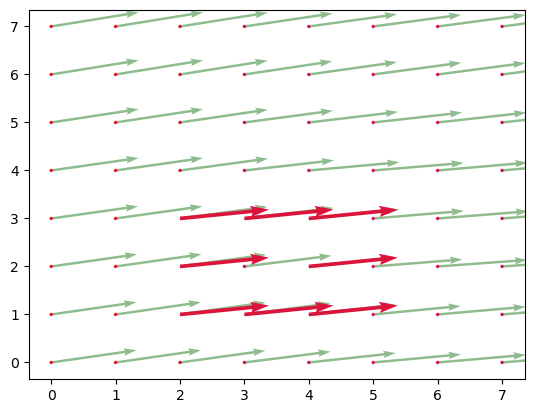

36 [4.09321388 2.86773388] [0.02694822 0.00303853]


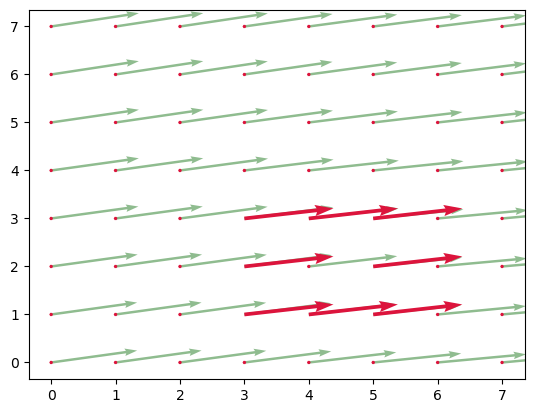

37 [4.20100674 2.87988801] [0.02687238 0.00342487]


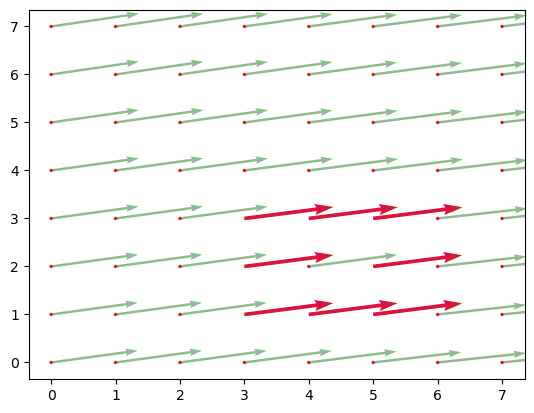

38 [4.30849625 2.89358751] [0.02674415 0.00393003]


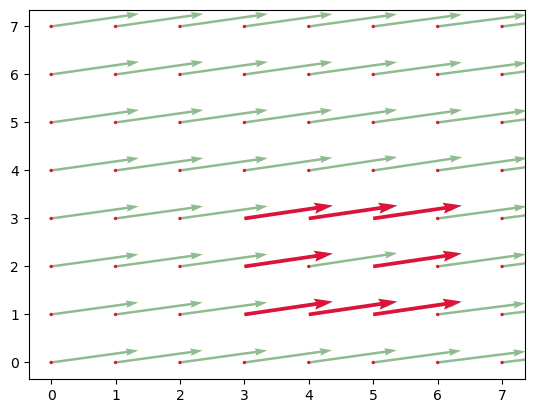

39 [4.41547287 2.90930764] [0.02663827 0.00455667]


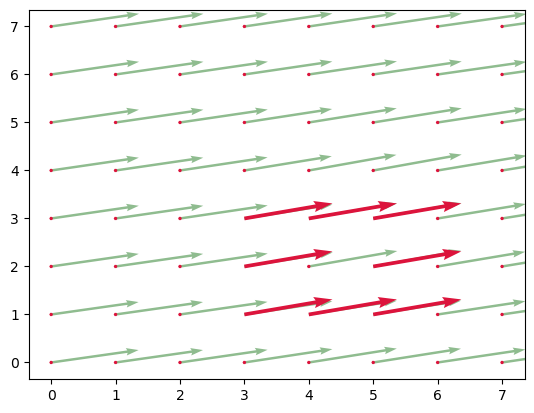

40 [4.52202597 2.92753432] [0.02650699 0.00529512]


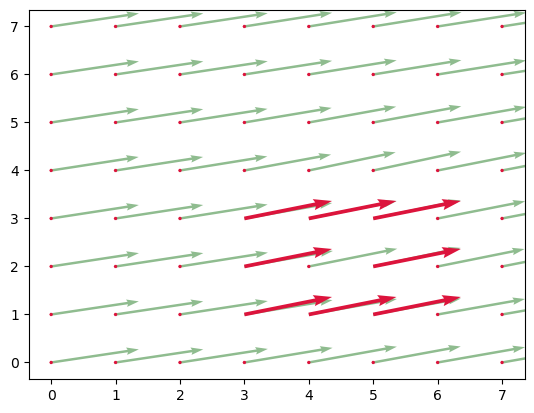

41 [4.62805394 2.94871478] [0.02636424 0.00622222]


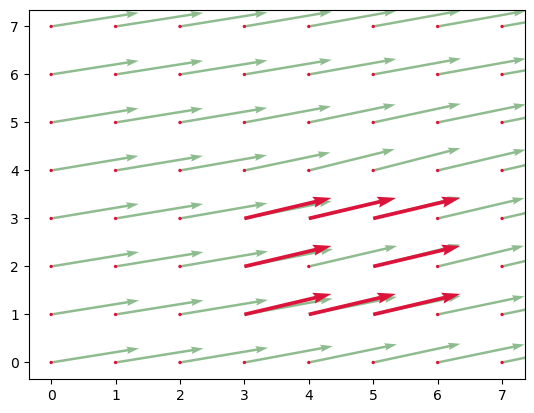

42 [4.73351091 2.97360365] [0.0262502  0.00724582]


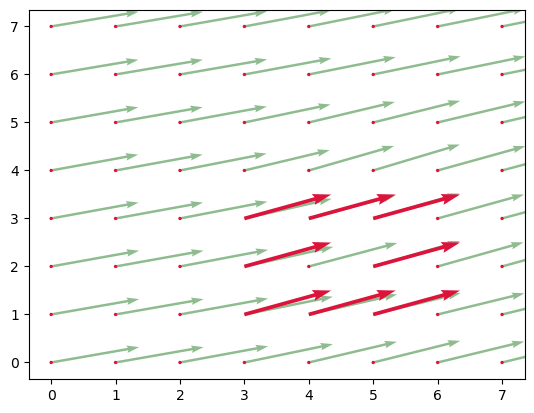

43 [4.83851172 3.00258692] [0.02607618 0.00829118]


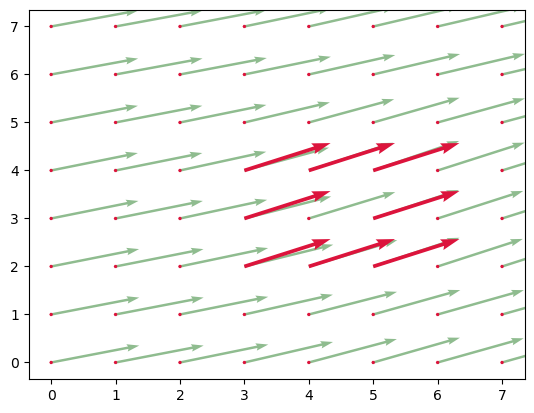

44 [4.94281643 3.03575164] [0.0257771  0.00950685]


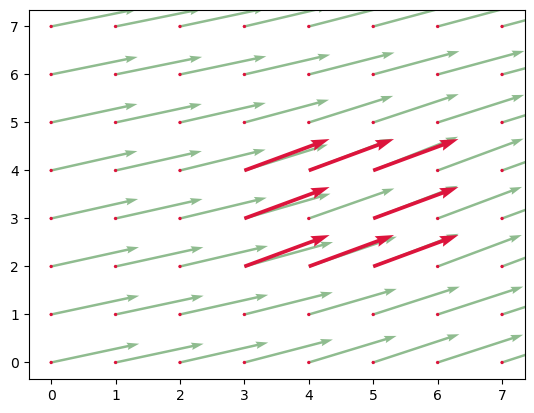

45 [5.04592484 3.07377903] [0.02547249 0.00990931]


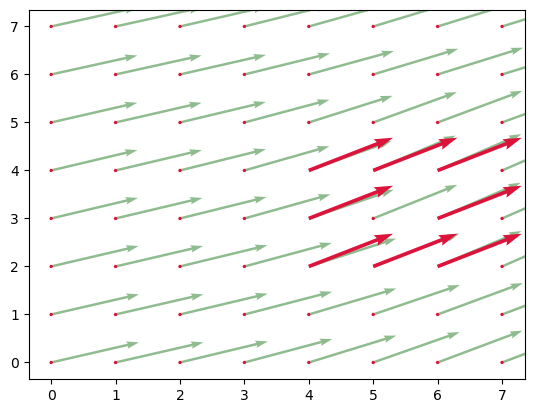

46 [5.1478148  3.11341627] [0.0247974  0.01059796]


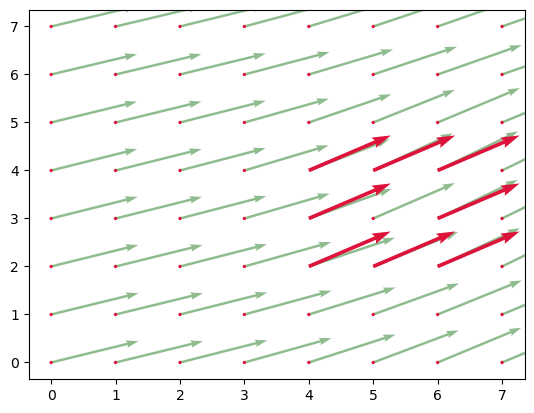

47 [5.24700441 3.1558081 ] [0.02424086 0.01093973]


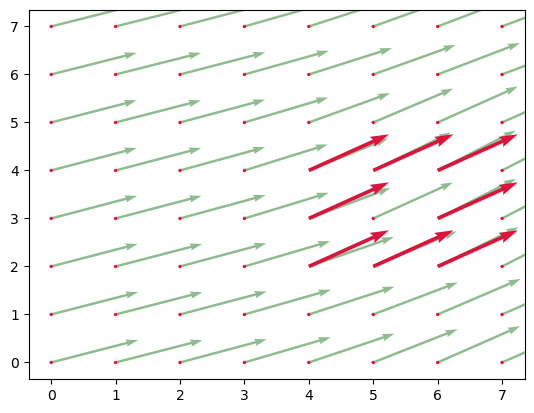

48 [5.34396786 3.19956703] [0.02317967 0.01112325]


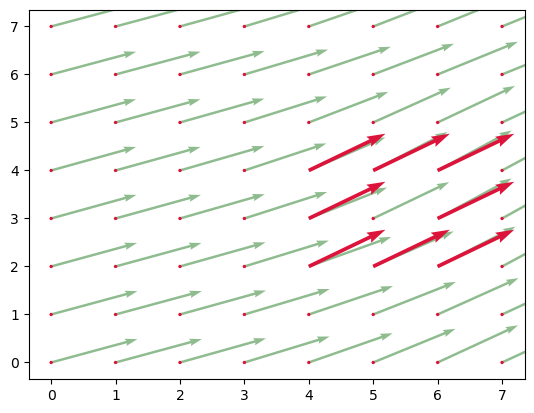

49 [5.43668655 3.24406004] [0.02231777 0.01110359]


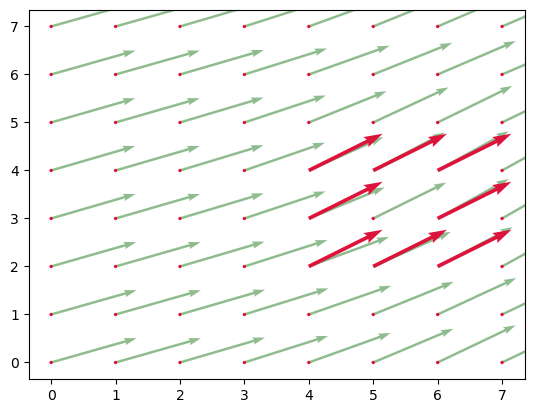

50 [5.52595763 3.28847441] [0.02133767 0.01092221]


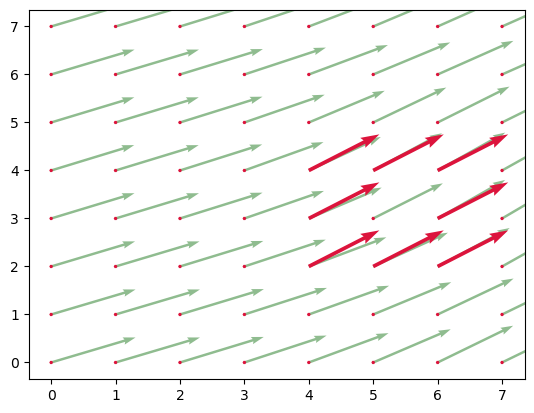

51 [5.6113083  3.33216324] [0.02018862 0.01053492]


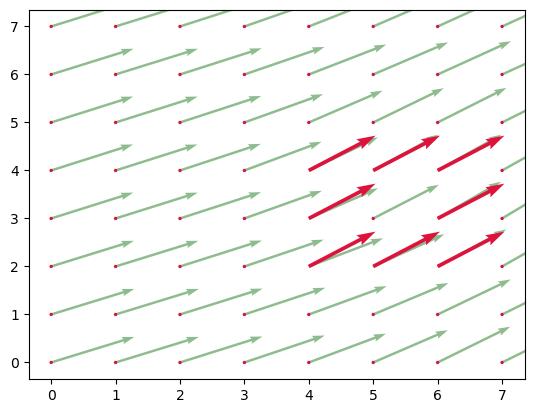

52 [5.69206279 3.37430292] [0.01937147 0.01023229]


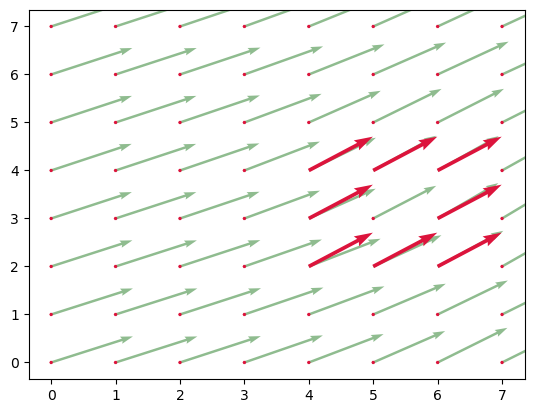

53 [5.76954865 3.41523206] [0.01848312 0.00979573]


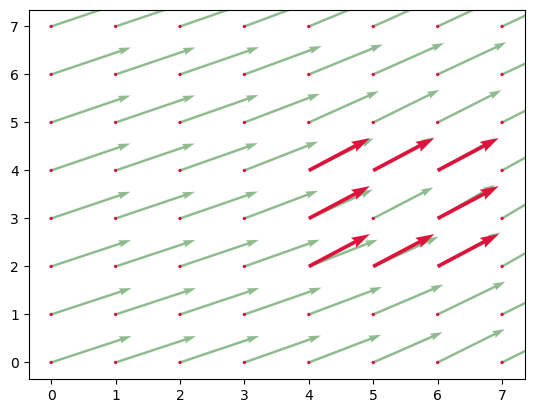

54 [5.84348112 3.45441498] [0.01791749 0.00957207]


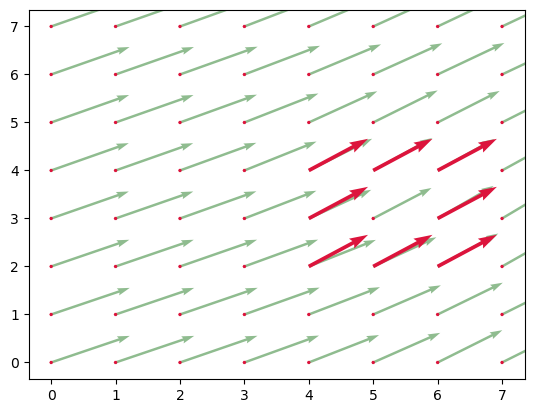

55 [5.91515106 3.49270328] [0.01749075 0.00942605]


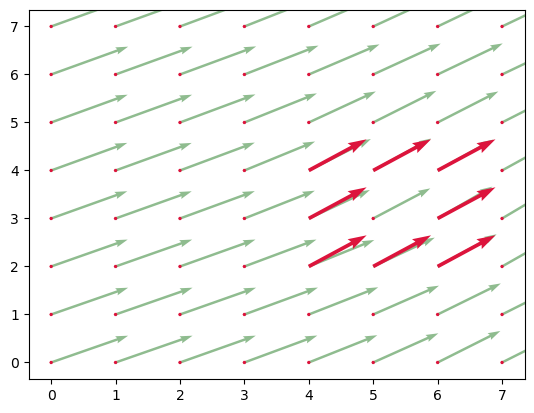

56 [5.98511408 3.53040747] [0.01707533 0.00925814]


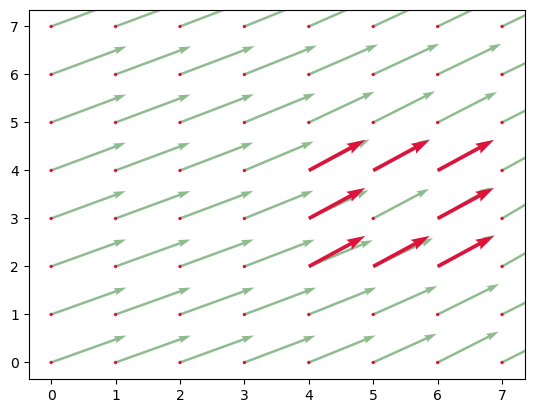

57 [6.05341541 3.56744002] [0.0166032  0.00900375]


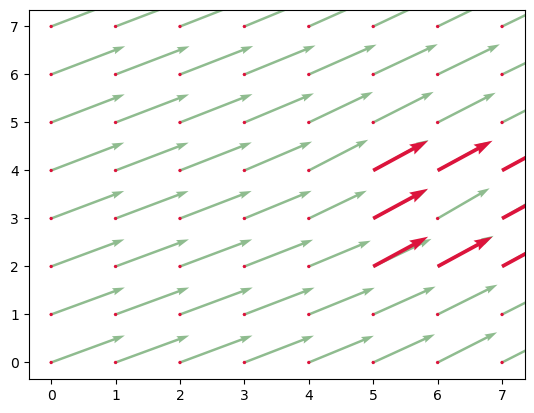

58 [6.11982822 3.60345504] [0.01623381 0.00880904]


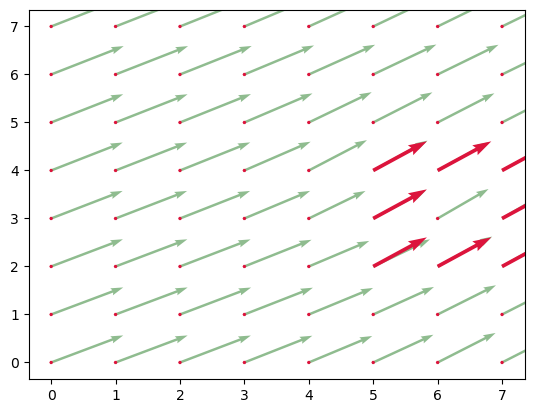

In [83]:
U_final = U.reshape((n_frames, height, width, 2))

test_body_movement = np.zeros_like(U_final)

test_body_poses = np.zeros((n_frames, 2))
test_body_vels = np.zeros((n_frames, 2))
boundary = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
# test_body_poses[0] = [2, 4]
test_body_poses[0] = [1, 1]


dt = 4

for frame in range(n_frames):
    u_frame = U_final[frame]

    body_vel = np.zeros(2)
    for b in boundary:
        p = test_body_poses[frame] + b
        body_vel += interpolation(u_frame, p[0], p[1])

    body_vel /= len(boundary)

    for b in boundary:
        p = test_body_poses[frame] + b
        test_body_movement[frame][int(p[0]), int(p[1])] = body_vel

    if (frame < n_frames - 1):
        test_body_poses[frame + 1] = test_body_poses[frame] + dt * body_vel

    print(frame, test_body_poses[frame], body_vel)

    plt.quiver(*P, np.array(u_frame[:, :, 0]), np.array(u_frame[:, :, 1]),
               color=['darkseagreen'], scale=0.15, width=0.005)
    
    plt.quiver(*P, np.array(test_body_movement[frame][:, :, 0]), np.array(test_body_movement[frame][:, :, 1]),
               color=['crimson'], scale=0.15)
    plt.savefig('example_ini_nondiv_free_body/frame_' + str(frame) + '.png')
    plt.show()
